# Introduction

This Notebook allow to create and visualize the dataset for this project.

Some functions was taked from "Visión por computadora" workshop by Mauricio Repetto & Waldemar López 

(https://drive.google.com/file/d/1neqSeyIqdpufL4EtY6jUirUvWGya0Mkp/view?usp=sharing)


# Imports

In [1]:
import numpy as np
import tensorflow as tf
import datetime; 
import pandas as pd
import matplotlib.pyplot as plt
import math

from shutil import copy2, rmtree, copytree
from tqdm import tqdm
from sys import stdout
from os import listdir, makedirs, remove
from os.path import isfile, join, isdir, exists, dirname, abspath
from inspect import getsourcefile
from tensorflow import keras
from numpy.random import seed
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from itertools import product

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Downloading dataset from Github

In [2]:
![ ! -d "dataset" ] && echo "Cloning dataset project from github" && git clone https://github.com/alphonse92/momo-dataset.git dataset 
!cd dataset
!# Set the dataset branch
!git checkout master
!# Force to reset if something
!git reset --hard
!git pull
!cd ..

Already on 'master'
Your branch is up to date with 'origin/master'.


In [3]:
# Load Inception V3.

InceptionV3             = keras.applications.inception_v3.InceptionV3
     
preprocess_input        = keras.applications.inception_v3.preprocess_input
image                   = keras.preprocessing.image
     
ImageDataGenerator      = keras.preprocessing.image.ImageDataGenerator
Callback                = keras.callbacks
     
Model                   = keras.models.Model
Sequential              = keras.models.Sequential
layers                  = keras.layers
     
Input                   = layers.Input
Dense                   = layers.Dense
Conv2D                  = layers.Conv2D
ZeroPadding2D           = layers.ZeroPadding2D
BatchNormalization      = layers.BatchNormalization
AveragePooling2D        = layers.AveragePooling2D
MaxPooling2D            = layers.MaxPooling2D
GlobalAveragePooling2D  = layers.GlobalAveragePooling2D




In [4]:
inceptionV3Model = InceptionV3(weights='imagenet', include_top=False, pooling=  'avg')

# Uncomment to describe the inception v3 summary model
#print(inceptionV3Model.summary())

# Notebook Configuration 


In [5]:
# Notebook Configuration
USE_INCEPTION_V3_MODEL = True
RESET_TRAINING_EXAMPLES = True
SAVE_WEIGHTS = True
SEED_APP = 9

# DATASET PROPORTIONS
TRAINING_PERCENTAGE = 0.7
TESTING_PERCENTAGE  = 0.15
EVAL_PERCENTAGE     = 0.15

# HYPERPARAMETERS
CRITERIA_THRESHOLD = 0.1
EPOCHS = 25
BATCH_SIZE = 15
IMG_W = IMG_H = 299

# MODEL CHECKPOINTS CONFIGURATION
SAVE_CHECKPOINTS = 5
SAVE_WEIGHTS_FREQUENCY = 'epoch'
SAVE_WEIGTHS_PERIOD = EPOCHS // SAVE_CHECKPOINTS

# COLAB SCOPE
GOOGLE_COLLAB = False                                                            # Default value. You should not modify this
GOOGLE_RESET_CONTENT_TREE = True                                                 # Reset the dataset content tree. It means remove and re copy the data from drive
MOUNT = "./"                                                                     # Base path of this project. You may not change this value   
G_MOUNT = "/content/drive"                                                       # Set where the drive folder will be mounted
G_PROJECT_PATH = G_MOUNT+ "/My Drive/Colab Notebooks/uruit-ml-momo-test/"        # Set the pathe where momo project is 

# If colab instance, then build the content tree
try:
  import google.colab
  from google.colab import drive
  drive.mount('/content/drive', force_remount=GOOGLE_RESET_CONTENT_TREE)
  GOOGLE_COLLAB = True
except:
  GOOGLE_COLLAB = False
  print(tf.test.gpu_device_name())
  

# Variables

In [35]:



tf.random.set_seed(SEED_APP)

MOMO_CLASSNAME    = "momo"
NO_MOMO_CLASSNAME = "no_momo"

DATASET_PATH = join(MOUNT, "dataset/")
RESULT_FOLDER_PATH = join(MOUNT,"result/")
VISUALIZATION_FOLDER = RESULT_FOLDER_PATH + "basic-predictions/"
VISUALIZATION_LATEST_RESULT_FOLDER = "latest/"
RESULT_FOLDER_WEIGHTS_INCEPTION_V3_PATH = RESULT_FOLDER_PATH + "inception_v3/"
DATESET_BASIC_PATH    = join(DATASET_PATH,'basic/')
DATESET_TRAINING_PATH = join(DATASET_PATH,'train/')
DATESET_TESTING_PATH  = join(DATASET_PATH,'test/')
DATESET_EVAL_PATH     = join(DATASET_PATH,'eval/')


DEFAULT_WEIGHTS_FILE_PATH = RESULT_FOLDER_WEIGHTS_INCEPTION_V3_PATH + 'weights.h5'

print(DATESET_BASIC_PATH)

./dataset/basic/


## Functions

In [44]:
def getFolders(path):
    return [d for d in listdir(path) if isdir(join(path, d))]

def getFolderFiles(path: str):
    return [f for f in listdir(path) if isfile(join(path, f))]  


def predict(path: str) -> np.array:
    img = image.load_img(path, target_size=(299, 299))
    # Size  (299, 299, 3)
    imgArray = image.img_to_array(img) 
    
    # Size  (1, 299, 299, 3)
    expandedImgArray = np.expand_dims(imgArray, axis=0) 
    
    # Preproces to inceptionV3, normalize each pixel RGB value to an scale of zero to one
    processedImgArray = preprocess_input(expandedImgArray) 
    
    return inceptionV3Model.predict(processedImgArray)

def getTimestamp():
    return datetime.datetime.now().timestamp()
    
def getRandomExample(xClass:str):

    exampleFileList = getFolderFiles(DATESET_BASIC_PATH + xClass)
    
    rndIndex = np.random.randint(0,len(exampleFileList))
    filename = exampleFileList[rndIndex]
    return join(DATESET_BASIC_PATH,xClass,filename)

def getClasses():
    return getFolders(DATESET_BASIC_PATH)
    
def createFolderIfNotExist(folderPath):
    if not exists(folderPath):
        makedirs(folderPath)

def deleteIfExist(filepath):
    if exists(filepath):
        remove(filepath)

def saveInFileIfNotExist(filepath: str, content: str):
  
    # Create (or not) the result folder
    createFolderIfNotExist(dirname(filepath))
    
    with open(filepath, mode="a") as f:
        f.write(content + '\n')
        
def saveResultFiles(filename,text):
    
    checkpointPredictionsPath  = VISUALIZATION_FOLDER + str(getTimestamp()) + "/"
    CHECKPOINT_FILEPATH        = checkpointPredictionsPath + filename
    saveInFileIfNotExist(CHECKPOINT_FILEPATH,text) 
    
    
    LATEST_FOLDER_PATH     = VISUALIZATION_FOLDER + VISUALIZATION_LATEST_RESULT_FOLDER
    LATEST_FILE_PATH       = LATEST_FOLDER_PATH  + filename
    deleteIfExist(LATEST_FILE_PATH)
    saveInFileIfNotExist(LATEST_FILE_PATH, text) 
        
        

# Observe a single example

In [8]:
np.random.seed(SEED_APP)

CLASSES = getClasses()
RANDOM_POSITIVE_EXAMPLE_PATH = getRandomExample("momo")
RANDOM_POSITIVE_EXAMPLE_FILE = predict(RANDOM_POSITIVE_EXAMPLE_PATH)
print("Momo class random file path" , RANDOM_POSITIVE_EXAMPLE_FILE)

predict(RANDOM_POSITIVE_EXAMPLE_PATH)


Momo class random file path [[0.55228573 0.8848897  0.43186566 ... 0.545951   0.63175106 0.49354166]]


array([[0.55228573, 0.8848897 , 0.43186566, ..., 0.545951  , 0.63175106,
        0.49354166]], dtype=float32)

# Create a CSV to visualize dataset data

In [9]:

# Create the folder structure to save the lates and an a checkpoint
CSV_NAME = "result.csv"
saveResultFiles(CSV_NAME, "class;image_name;predictions") 

for _class_ in CLASSES:
    classFolderPath = join(DATESET_BASIC_PATH, _class_)
    imagePaths = getFolderFiles(classFolderPath)
    
    print(f"Processing {_class_}...")
    
    for imgName in tqdm(imagePaths, file=stdout):
        imagePath = join(classFolderPath, imgName)
        # Inception V3 return an array of (1,2048)
        try:
            predictions = predict(imagePath)

            # Get a CSV row for the current class,image and prediction
            csvRow = f'"{_class_}";"{imgName}";"{",".join([ str(pred) for pred in predictions[0]])}"'
            saveResultFiles(CSV_NAME, csvRow) 

        except Exception:
            print("\nCan't to load: " , imagePath, "Please check your dataset and remove it if it is required\n")
            


Processing meme...
100%|██████████| 60/60 [00:08<00:00,  7.50it/s]
Processing person...
100%|██████████| 88/88 [00:08<00:00, 10.07it/s]
Processing momo...
100%|██████████| 434/434 [00:39<00:00, 11.08it/s]


In [43]:
LATEST_RESULT_CSV_PATH =  VISUALIZATION_FOLDER + VISUALIZATION_LATEST_RESULT_FOLDER + "result.csv"
print("Loading latest csv:" , LATEST_RESULT_CSV_PATH)

# Create dataframe with pandas
df = pd.read_csv(LATEST_RESULT_CSV_PATH, sep=';')

# Check the head
df.head()




Loading latest csv: ./result/basic-predictions/latest/result.csv


,class,image_name,predictions
0,meme,meme_tmplimage59.jpg,"0.37360469,0.09190824,0.004368141,0.31041825,1..."
1,meme,meme_tmplimage9.jpg,"0.43767205,0.22983317,0.00991118,0.44174778,0...."
2,meme,meme_tmplimage71.jpg,"0.51454926,0.57877517,0.05983212,0.074780315,0..."
3,meme,meme_tmplimage65.jpg,"0.19602767,0.2568739,0.06481302,0.1758996,0.89..."
4,meme,meme_tmplimage70.jpg,"0.069468334,0.4723937,0.16628663,0.09185074,0...."


In [11]:
# Get the predictions as float
df['predictions_float'] = df['predictions'].apply(lambda x: np.array([float(str_dim) for str_dim in x.split(',')], dtype=np.float32))

# Save as np array the predictions per record
vectors = np.array(df['predictions_float'].tolist())

# Print the size (m,2048) where m is the length of our dataset. and 2048 is the predictions
# For each class in inception
print("vectors" , vectors.shape)

resultLabelsFileName = "result_labels.tsv"
resultEmbdingsFilename = "result_embdings.tsv"

# Write the labels tsv file
saveResultFiles(resultLabelsFileName ,"Index\tLabel\n")
for index,(file, label) in enumerate(zip(df.image_name, df["class"])):
    saveResultFiles(resultLabelsFileName, f'{label} - {file}\t{label}\n')

# Write the vectors TSV file
for dims in vectors:
    saveResultFiles(resultEmbdingsFilename,'\t'.join([str(dim) for dim in dims])+'\n')

vectors (582, 2048)


# Visualize the data using tensorflow embding projection

This tool allow to users to visualize him data. Use the last folder in result/basic-predictions/

## Steps

1. Click on Load buttom
2. In step 1 select the file `result_embdings.tsv`
3. In step 2 select the file `result_labels.tsv`
4. Click outside the modal

You should see something like this:

![screenshot using tf embding projector](./docs/tensorflowEmbdingProjector.png)

# PCA 2 dimension Visualization 

In [12]:
# Scaling the data before
vectors_std = StandardScaler().fit_transform(vectors)

In [13]:
vectors[0:10]

array([[3.73604685e-01, 9.19082388e-02, 4.36814083e-03, ...,
        5.88361546e-03, 3.38844806e-01, 2.94581838e-02],
       [4.37672049e-01, 2.29833171e-01, 9.91117954e-03, ...,
        1.14202768e-01, 2.80727208e-01, 2.40652144e-01],
       [5.14549255e-01, 5.78775167e-01, 5.98321185e-02, ...,
        4.11029488e-01, 5.15095770e-01, 2.79301882e-01],
       ...,
       [6.57679066e-02, 1.56305954e-01, 4.48732644e-01, ...,
        1.06274365e-02, 6.69762313e-01, 1.07211709e+00],
       [1.91122770e-01, 2.20589042e-01, 5.84478796e-01, ...,
        2.50498563e-01, 6.63940489e-01, 7.08679259e-01],
       [1.53123602e-01, 1.02330245e-01, 4.17783624e-04, ...,
        3.20425898e-01, 5.95992267e-01, 4.54699323e-02]], dtype=float32)

In [14]:
vectors_std[0:10]

array([[-0.17097917, -1.1451987 , -0.85773593, ..., -1.5633544 ,
        -0.22198527, -1.1689783 ],
       [ 0.06159008, -0.608786  , -0.8361486 , ..., -1.2438059 ,
        -0.37138653, -0.36245617],
       [ 0.34065998,  0.74830675, -0.6417317 , ..., -0.3681476 ,
         0.23109804, -0.21485788],
       ...,
       [-1.2884493 , -0.8947454 ,  0.8728396 , ..., -1.5493599 ,
         0.6286949 ,  2.8128002 ],
       [-0.8334019 , -0.6447379 ,  1.4015024 , ..., -0.84172434,
         0.6137289 ,  1.4248784 ],
       [-0.97134167, -1.1046658 , -0.8731206 , ..., -0.63543415,
         0.43905634, -1.1078316 ]], dtype=float32)

In [15]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(vectors_std)
print(principalComponents.shape)
pca.explained_variance_ratio_

(582, 2)


array([0.06608571, 0.05315619], dtype=float32)

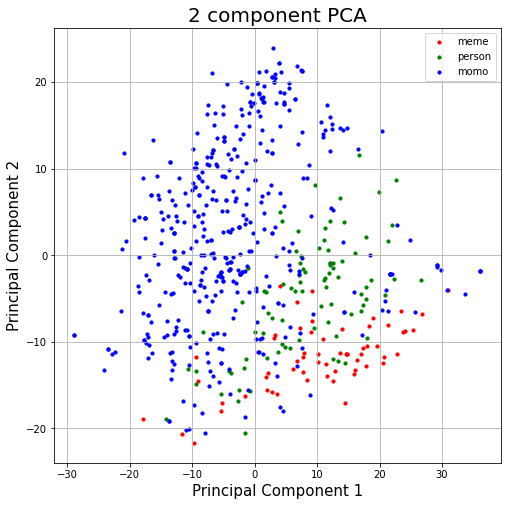

In [16]:
# Plotting using matplot lib

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)

ax.set_title('2 component PCA', fontsize = 20)

targets = getClasses()
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df['class'] == target    
    ax.scatter(principalComponents[indicesToKeep][:,0:1]
               , principalComponents[indicesToKeep][:,1:2]
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()